In [1]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mlutils
reload(mlutils)
%matplotlib inline

/opt/miniconda/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Tareas de analítica de imágenes

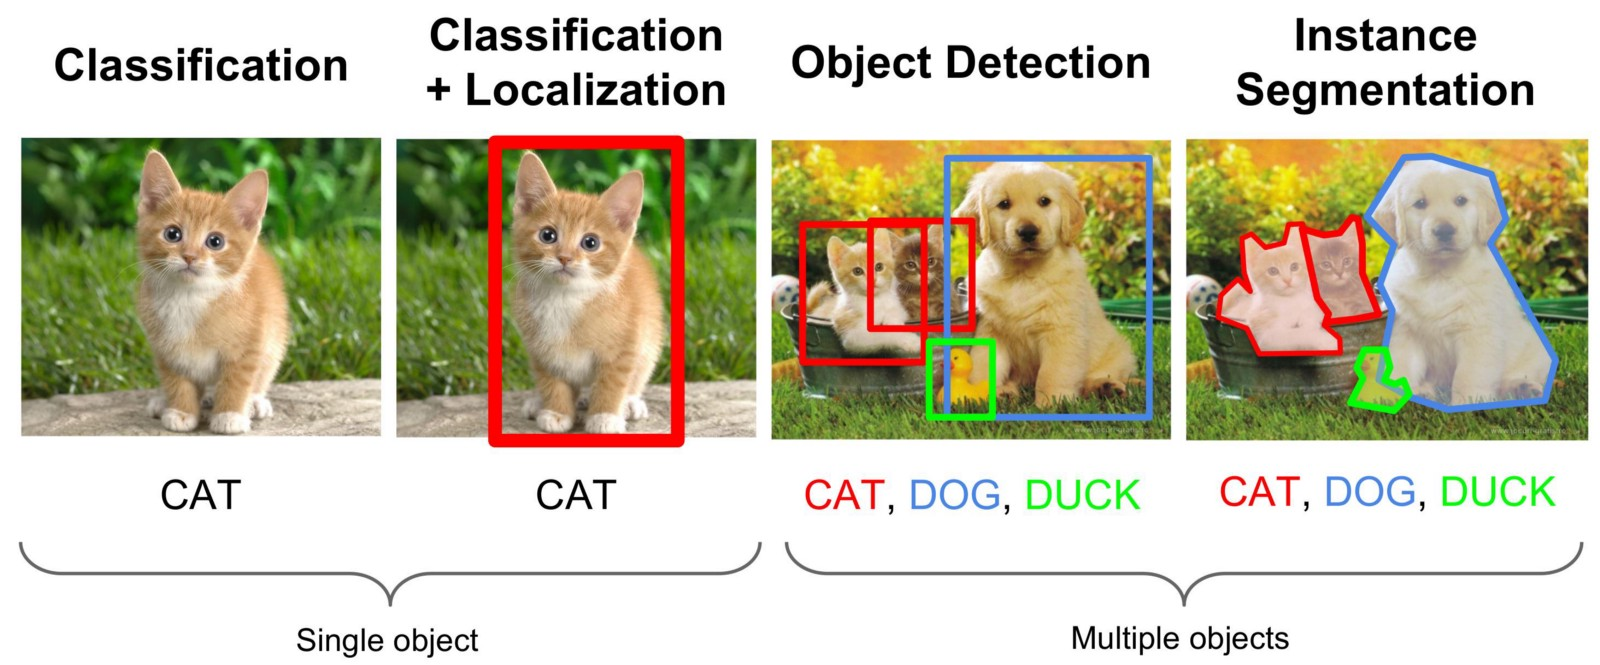

In [1]:
from IPython.display import Image
Image(filename='imgs/imgs_tasks.jpeg', width=800)

### Explora el [COCO Dataset](http://cocodataset.org/)

**also**

- Image APIs [Clarifai](https://clarifai.com/demo) [Amazon Rekognition](https://aws.amazon.com/rekognition/), [Google Cloud Vision](https://cloud.google.com/vision/docs/drag-and-drop)
- Image Captioning (con CNN + RNN!!!) [caption bot](https://www.captionbot.ai/)



## Convolutional Neural Networks

see https://cloud.google.com/blog/big-data/2017/01/learn-tensorflow-and-deep-learning-without-a-phd

see [filter activation demo](http://ml4a.github.io/demos/convolution_all/) [confusion matrix](http://ml4a.github.io/demos/confusion_cifar/)

### RECOMENDACIÓN

- cierra todas las aplicaciones
- instala el navegador Maxthon http://www.maxthon.com
- abre sólo VirtualBox y Maxthon

## Filtros y mapas de activación de primer nivel

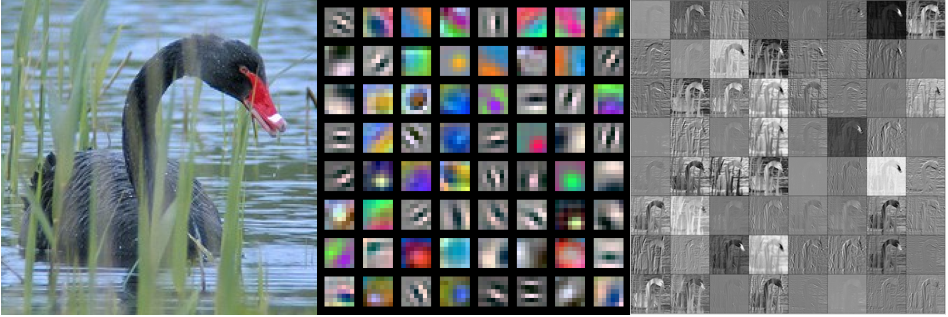

In [1]:
Image(filename='imgs/cnn_swan.png', width=800)

## Jerarquía de filtros y mapas de activación

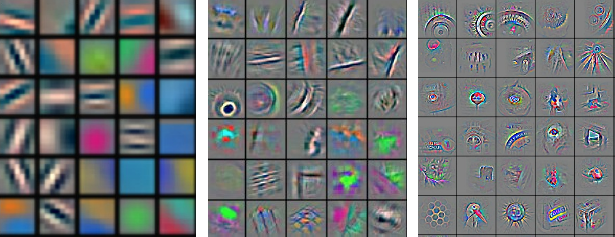

In [2]:
Image(filename='imgs/cnn_features.png', width=600)

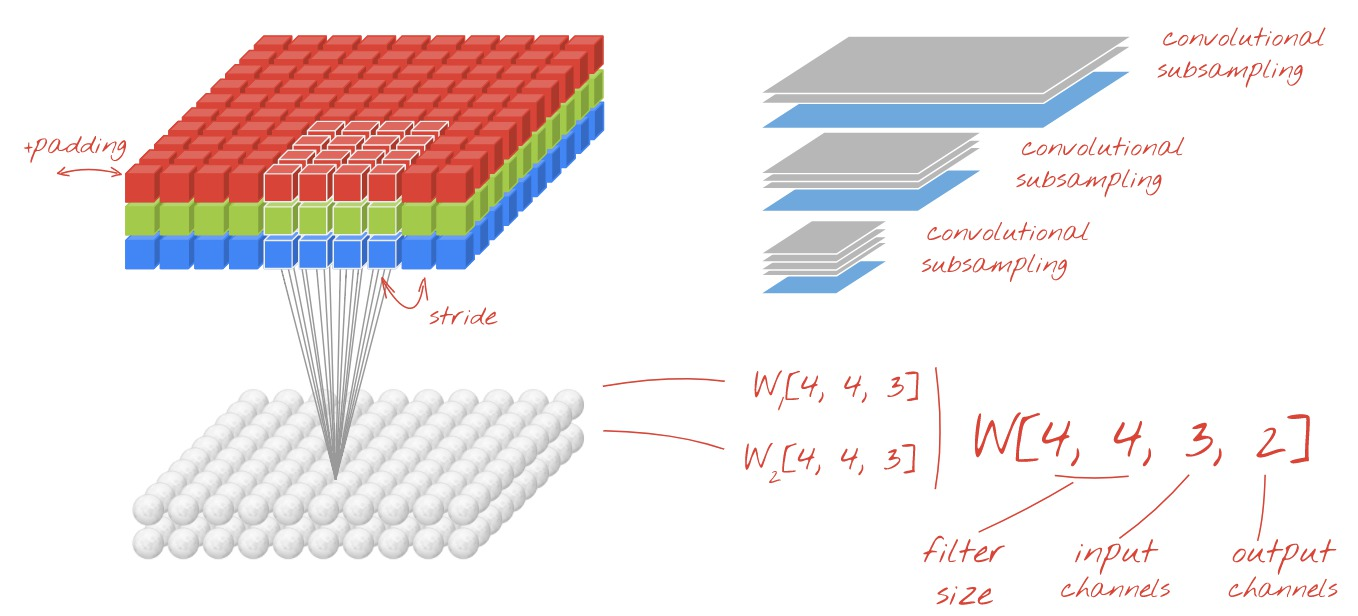

In [3]:
Image(filename='imgs/conv1.jpg', width=800)

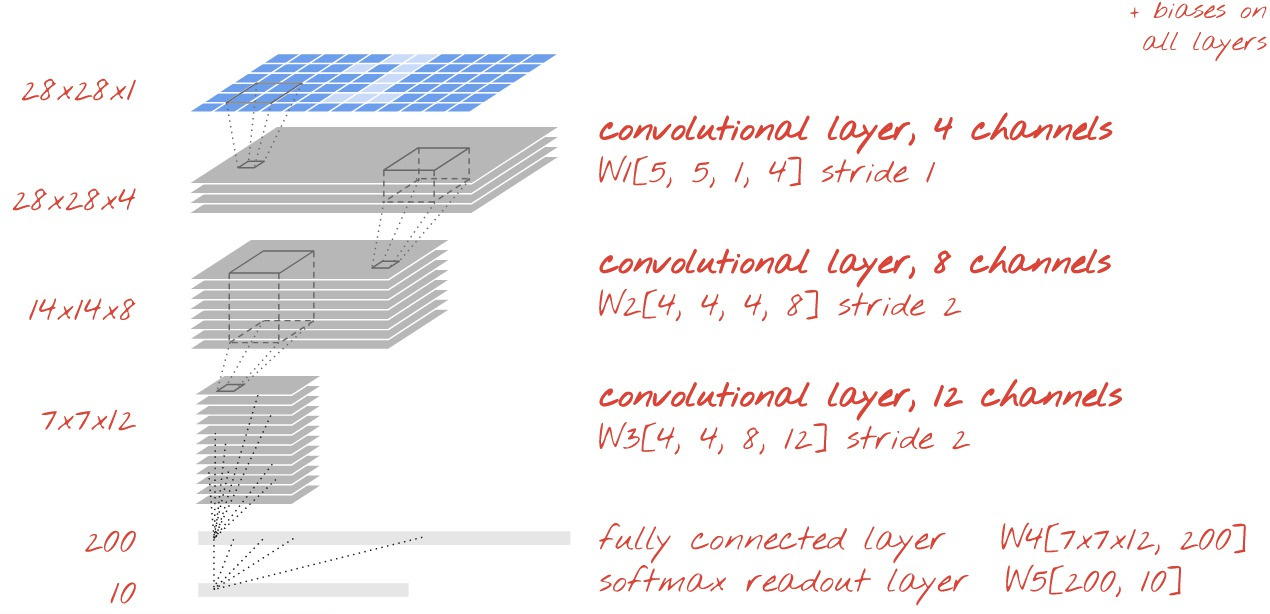

In [4]:
Image(filename='imgs/conv2.jpg', width=800)

a la siguiente imagen se le aplican los filtros adjuntos. Observa, por ejemplo, que qué partes de la imagen se activa el penúltimo filtro de la primera fila

otros ejemplos de filtros de primer nivel

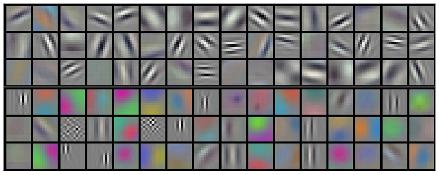

In [6]:
Image(filename='imgs/cnn_features2.png', width=600)

Tenemos un pequeño dataset de imágenes basado en [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html).

- cada imagen es de **32x32x3**.
- las imágenes se **linearizan** para la red que ensamblamos con Keras, compuesta por capas tradicionales (**Dense**).
- en ejemplos más sofisticados usaríamos **capas convolucionales** que explotan las correlaciones 2D propias de las imágenes.

In [7]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5

File ‘mini_cifar.h5’ already there; not retrieving.



In [8]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

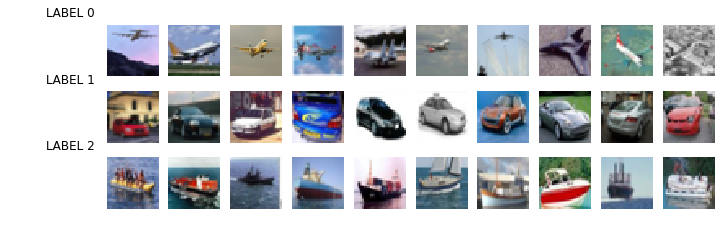

In [9]:
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print x_train.shape, y_train.shape, x_test.shape, y_test.shape
print "\ndistribution of train classes"
print pd.Series(y_train).value_counts()
print "\ndistribution of test classes"
print pd.Series(y_test).value_counts()

(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
2    765
0    751
1    737
dtype: int64

distribution of test classes
2    260
0    254
1    237
dtype: int64


construimos el modelo con Keras

In [12]:
def get_conv_model_A(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(3,3), activation="relu")(inputs)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [13]:
num_classes = len(np.unique(y_cifar))
model = get_conv_model_A(num_classes)

using 3 classes


observa los pesos inicializados y sus tamaños

In [14]:
weights = model.get_weights()
for i in weights:
    print i.shape

(3, 3, 3, 15)
(15,)
(13500, 16)
(16,)
(16, 3)
(3,)


guardarmos los filtros de la primera capa para compararlos con los mismos filtros después del entrenamiento

In [15]:
initial_w0 = model.get_weights()[0].copy()

In [16]:
y_test.shape, y_train.shape, x_test.shape, x_train.shape

((751,), (2253,), (751, 32, 32, 3), (2253, 32, 32, 3))

In [17]:
num_classes = len(np.unique(y_cifar))

def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}


In [18]:
model = get_conv_model_A(num_classes)
model.summary()
train(model, batch_size=32, epochs=10, model_name="model_A")

using 3 classes
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 15)        420       
_________________________________________________________________
flatten (Flatten)            (None, 13500)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                216016    
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
output_1 (Dense)             (None, 3)                 51        
Total params: 216,487
Trainable params: 216,487
Non-trainable params: 0
______________________________________________________

{'acc': 0.6964047940847242, 'loss': 0.7868409600461053}

observa la salida en tensorboard

    tensorboard --logdir logs

filtros de la primera capa antes del entrenamiento


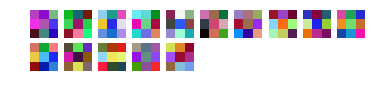

In [19]:
mlutils.display_imgs(initial_w0)

(3, 3, 3, 15)


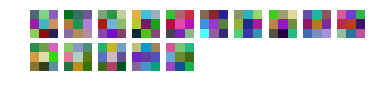

In [20]:
w0 = model.get_weights()[0]
print w0.shape
mlutils.display_imgs(w0)

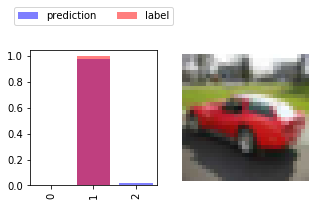

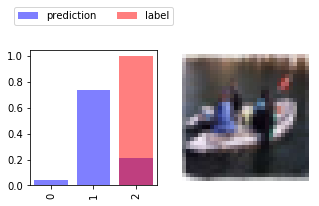

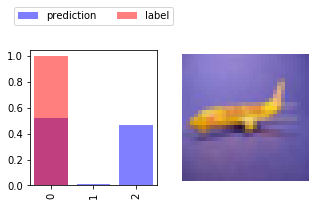

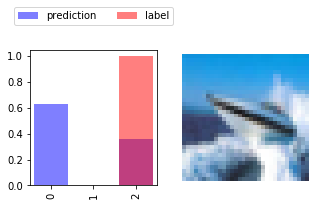

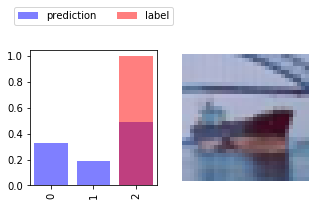

In [21]:
idxs = np.random.permutation(len(x_test))[:5]
preds = model.predict(x_test[idxs])
mlutils.show_preds(x_test[idxs],y_test[idxs], preds)

### Probemos con una red más completa

In [23]:
def get_conv_model_B(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(5,5), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(5,5), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [24]:
model = get_conv_model_B(num_classes)
model.summary()
train(model, batch_size=32, epochs=10, model_name="model_B")

using 3 classes
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 15)        1140      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 15)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 60)        22560     
_________________________________________________________________
flatten (Flatten)            (None, 6000)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                96016     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0    

{'acc': 0.7683089215174496, 'loss': 0.5703805993384273}

(5, 5, 3, 15)


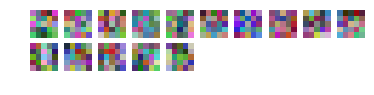

In [26]:
w0 = model.get_weights()[0]
print w0.shape
mlutils.display_imgs(w0)

### o con filtros más grandes

In [29]:
def get_conv_model_C(num_classes, img_size=32, compile=True):
    tf.reset_default_graph()
    tf.keras.backend.clear_session()
    print "using",num_classes,"classes"
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [30]:
model = get_conv_model_C(num_classes)
model.summary()
train(model, batch_size=32, epochs=10, model_name="model_C")

using 3 classes
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                976       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0    

{'acc': 0.6711051933933669, 'loss': 0.7690623764509209}

(11, 11, 3, 96)


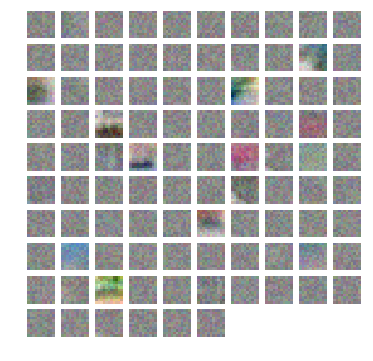

In [32]:
w0 = model.get_weights()[0]
print w0.shape
mlutils.display_imgs(w0)

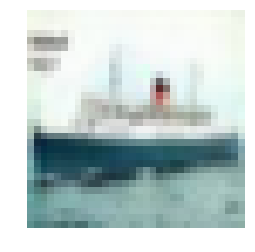

In [50]:
i = np.random.randint(len(x_test))
plt.imshow(x_test[i])
plt.axis("off");

In [51]:
acts = mlutils.get_activations(model, x_test[i:i+1])["conv2d/Relu:0"][0]

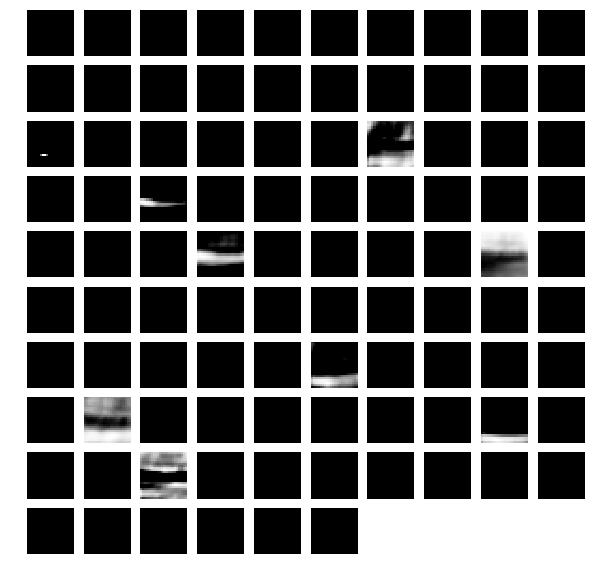

In [52]:
plt.figure(figsize=(10,10))
for i in range(acts.shape[-1]):
    plt.subplot(10,10,i+1)
    plt.imshow(acts[:,:,i], cmap=plt.cm.Greys_r )
    plt.axis("off")

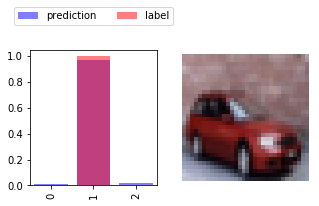

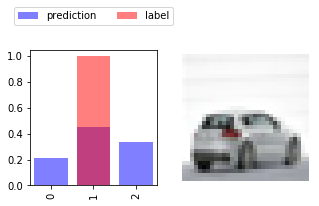

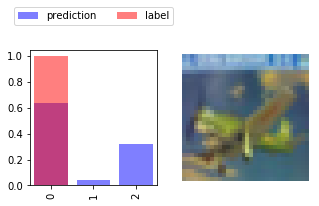

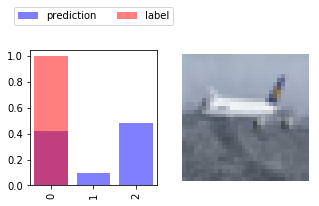

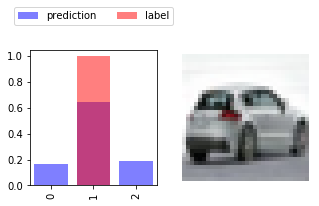

In [53]:
idxs = np.random.permutation(len(x_test))[:5]
preds = model.predict(x_test[idxs])
mlutils.show_preds(x_test[idxs],y_test[idxs], preds)

see 

- https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
- https://deepdreamgenerator.com/  

**Class activation maps**
https://jacobgil.github.io/deeplearning/class-activation-maps